In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score
from itertools import product
from scipy.sparse import coo_matrix
from scipy.stats import spearmanr
from utils_plot import *

In [2]:
# 1. Data Normalization
def preprocessing(alpha1, alpha2, N, ampl_threshold=0):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
     
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    #N_norm = N - np.mean(N, axis=0, keepdims=True) #We will optimize the sparse matrix

    return alpha1_norm, alpha2_norm, N, targetnames_filtered, tf_names_filtered

In [3]:
# 2 Define Ridge Regression Model with Trainable Sparse W
class TrainableModel(nn.Module):
    def __init__(self, N, alpha, num_tfs, num_thetas, lambda1=0.01, lambda2=0.01):
        super(TrainableModel, self).__init__()
        
        self.lambda1 = lambda1  # L1 regularization for W
        self.lambda2 = lambda2  # L2 regularization for A

        # Convert N to COO format
        sparse_matrix = coo_matrix(N)

        # Get the nonzero indices and values
        self.i = torch.tensor(sparse_matrix.row, dtype=torch.long)
        self.j = torch.tensor(sparse_matrix.col, dtype=torch.long)
        values = torch.tensor(sparse_matrix.data, dtype=torch.float32)

        # Create W as a trainable vector for the non-zero elements of N
        self.W = nn.Parameter(torch.randn(len(values)) * 0.01)

        # Initialize the unconstrained TF activity parameters
        self.x = nn.Parameter(torch.randn(num_tfs, num_thetas) * 0.01)

        self.num_genes, self.num_tfs = N.shape

    def forward(self):
        # Create a sparse tensor for W
        W_sparse = torch.sparse_coo_tensor(
            indices=torch.stack([self.i, self.j]), 
            values=self.W, 
            size=(self.num_genes, self.num_tfs)
        )
        W_dense_tensor = W_sparse.to_dense()

        # Constrain A to be between 0 and 1 using the sigmoid function.
        A = torch.sigmoid(self.x)

        # Compute the reconstructed alpha matrix.
        return torch.matmul(W_dense_tensor, A)

    def loss(self, alpha_true):
        alpha_pred = self.forward()
        mse_loss = torch.mean((alpha_true - alpha_pred) ** 2)
        l1_loss = torch.sum(torch.abs(self.W))  # L1 on W
        l2_loss = torch.sum(self.x ** 2)         # L2 on the unconstrained A

        total_loss = mse_loss + self.lambda1 * l1_loss + self.lambda2 * l2_loss
        return total_loss

In [4]:
def train_model(N, alpha, alpha_test, lambda1, lambda2, patience=20, num_epochs=1000, lr=0.005):
    num_genes, num_tfs = N.shape
    num_thetas = alpha.shape[1]
    
    model = TrainableModel(N, alpha, num_tfs, num_thetas, lambda1, lambda2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_EV = -float("inf")
    patience_counter = 0

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = model.loss(alpha)
        loss.backward()
        optimizer.step()

        # Validation Step
        W_dense = torch.sparse_coo_tensor(
            indices=torch.stack([model.i, model.j]), 
            values=model.W.detach(), 
            size=(num_genes, num_tfs)
        ).to_dense().numpy()
        x = model.x.detach()
        A = torch.sigmoid(x).numpy()
        R_test = W_dense @ A
        EV_test = explained_variance_score(alpha_test.numpy(), R_test)

        # Check for early stopping
        if EV_test > best_EV+0.005:
            best_EV = EV_test
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, EV_test: {EV_test*100:.2f}%")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best EV_test: {best_EV*100:.2f}%")
            break

    return W_dense, A, x.numpy()

In [5]:
# 4. Cross-Validation for Lambda Optimization
def cross_val_lambda(N, alpha1, alpha2, lambda1_values, lambda2_values):
    best_lambda1, best_lambda2, best_EV = None, None, -np.inf

    for lambda1, lambda2 in product(lambda1_values, lambda2_values):
        print(f"Testing lambda1 = {lambda1}, lambda2 = {lambda2}")

        # Train on alpha1, test on alpha2
        W1, A1, x1 = train_model(N, alpha1, alpha2, lambda1, lambda2)
        R_test1 = W1 @ A1
        EV1 = explained_variance_score(alpha2, R_test1)

        # Train on alpha2, test on alpha1
        W2, A2, x2 = train_model(N, alpha2, alpha1, lambda1, lambda2)
        R_test2 = W2 @ A2
        EV2 = explained_variance_score(alpha1, R_test2)

        avg_EV = (EV1 + EV2) / 2
        print(f"Lambda1={lambda1}, Lambda2={lambda2}, EV={avg_EV*100:.2f}%\n")

        if avg_EV > best_EV:
            best_lambda1, best_lambda2, best_EV = lambda1, lambda2, avg_EV

    print(f"Best λ1 = {best_lambda1}, Best λ2={best_lambda2}, Best EV={best_EV*100:.2f}%\n")
    return best_lambda1, best_lambda2

In [6]:
# 5. Cross train for best model
def cross_train(N, alpha1, alpha2, best_lambda1, best_lambda2):
    print("Training on α1, testing on α2...")
    W1, A1, x1 = train_model(N, alpha1, alpha2, best_lambda1, best_lambda2)
    R_test1 = W1 @ A1
    EV1 = explained_variance_score(alpha2.numpy(), R_test1)

    print("Training on α2, testing on α1...")
    W2, A2, x2 = train_model(N, alpha2, alpha1, best_lambda1, best_lambda2)
    R_test2 = W2 @ A2
    EV2 = explained_variance_score(alpha1.numpy(), R_test2)

    avg_EV = (EV1 + EV2) / 2
    print(f"Average EV: {avg_EV*100:.2f}%")
    
    return W1, A1, x1, W2, A2, x2

In [7]:
def standardize_amplitudes(matrices, target_amp=0.2):
    """
    Rescale the matrices to a single target amplitude.
    """
    standardized_matrices = []
    for matrix in matrices:
        amp = (np.max(matrix, axis=1) - np.min(matrix, axis=1)) / 2
        scale = target_amp / amp
        standardized_matrix = matrix * scale[:, np.newaxis]
        standardized_matrices.append(standardized_matrix)
    
    return standardized_matrices

In [8]:
# Load Data & Run
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
torch.manual_seed(42)

# Define Lambda Values
#lambda1_values = np.logspace(-7, -5, 3)
#lambda2_values = np.logspace(-5, -3, 3)
best_lambda1, best_lambda2 = 1e-7, 1e-7

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.1
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape, "\n")

N_tensor = torch.tensor(N_norm, dtype=torch.float32)  # (genes, TFs)
alpha1_tensor = torch.tensor(alpha1_norm, dtype=torch.float32)  # (genes, thetas)
alpha2_tensor = torch.tensor(alpha2_norm, dtype=torch.float32)  # (genes, thetas)

# Optimize Lambda
#best_lambda1, best_lambda2 = cross_val_lambda(N_tensor, alpha1_tensor, alpha2_tensor, lambda1_values, lambda2_values)

# Train and Cross-Test
W1, A1, x1, W2, A2, x2 = cross_train(N_tensor, alpha1_tensor, alpha2_tensor, best_lambda1, best_lambda2)

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 4
Kept genes: 2399 (ampl > 0.1)
(2399, 100) (2399, 100) (2399, 366) 

Training on α1, testing on α2...
Epoch 0, Loss: 0.0343, EV_test: -4.79%
Epoch 100, Loss: 0.0059, EV_test: 50.34%
Early stopping at epoch 171. Best EV_test: 55.19%
Training on α2, testing on α1...
Epoch 0, Loss: 0.0313, EV_test: -4.55%
Epoch 100, Loss: 0.0055, EV_test: 51.57%
Early stopping at epoch 175. Best EV_test: 58.10%
Average EV: 57.09%


In [9]:
print(np.sort(W1.flatten()))
print(np.sort(x1.flatten()))
print(np.sort(A1.flatten()))

[-1.1418005 -1.0839831 -1.0593249 ...  1.0043788  1.0196944  1.0634795]
[-1.0485643 -1.0386271 -1.0385674 ...  1.0424066  1.0442218  1.0451092]
[0.2595009  0.26141497 0.2614265  ... 0.7393141  0.7396638  0.7398346 ]


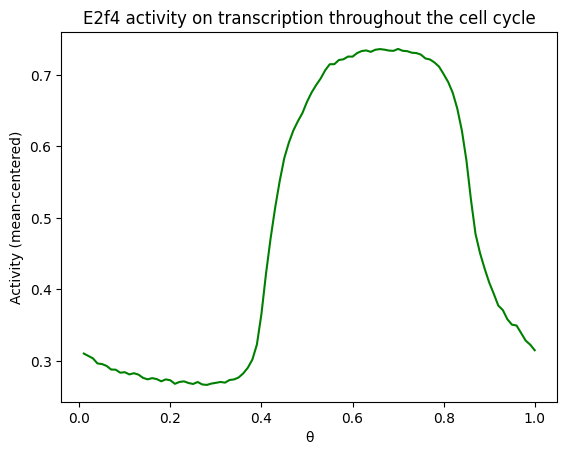

In [10]:
BP_nb = np.where(tf_names == 'E2f4')[0][0]
#BP_nb = 190
plot_binding_protein_activity(tf_names, A1, process, theta_smooth, BP_nb=BP_nb)

Train


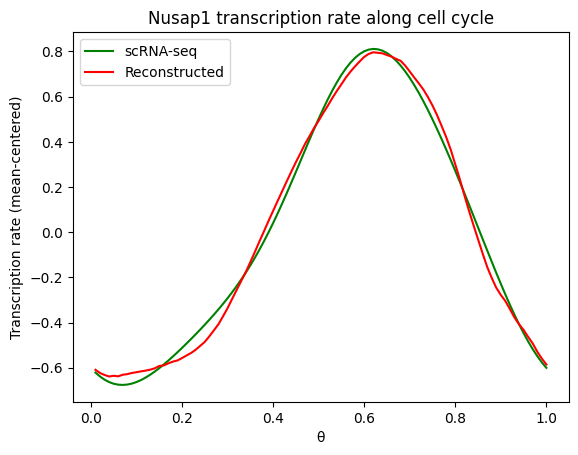

Test


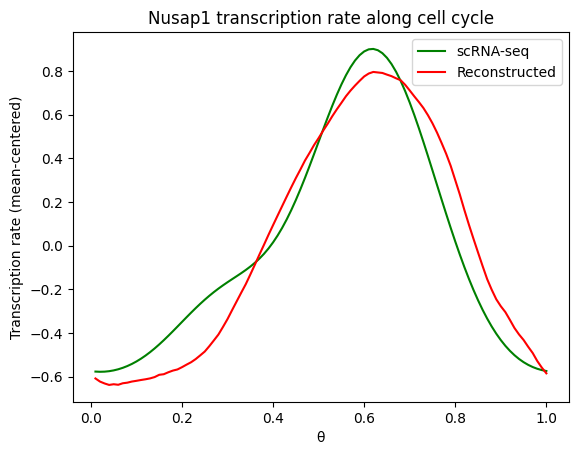

In [11]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 4972
print("Train")
plot_rate_comparison(targetnames, alpha1_tensor, W1 @ A1, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, alpha2_tensor, W1 @ A1, process, theta_smooth, target_nb=n)

['E2f1' 'Smad3' 'E2f2_E2f5' 'Tfap4' 'Hbp1' 'Hes1' 'E2f8' 'E2f6' 'Elf3'
 'E2f7' 'E2f4' 'E2f3' 'Sp1']


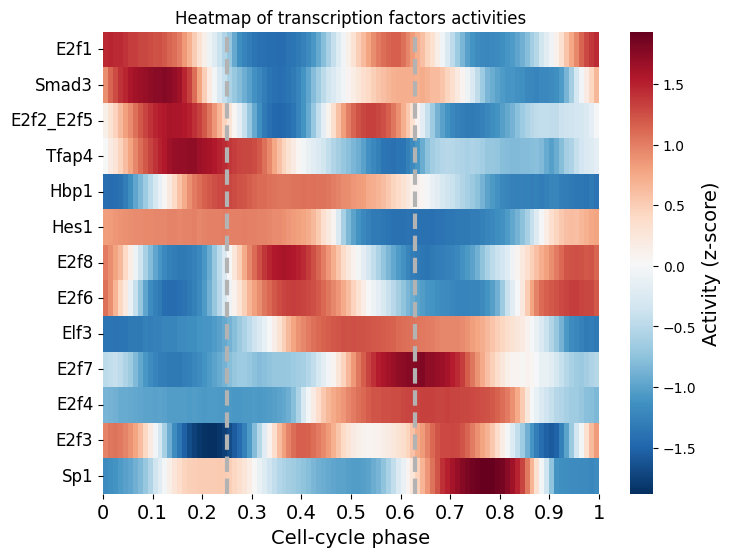

In [12]:
#Heatmap of BPs activity along cell cycle (Export)
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2_E2f5", "E2f3", "E2f4", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1", "Elf3", "Tfap4"]
tf_displayed = plot_heatmap_list(A1, tf_names, key_tfs)
print(tf_displayed)

In [13]:
expected_activity = {
    "Smad3": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "Hbp1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "E2f1": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f2_E2f5": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f3": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f4": {"ranges": [(0.01, 0.25)], "inhibitory": False}, #May be True
    "E2f6": {"ranges": [(0.01, 0.25), (0.63, 0.9)], "inhibitory": False}, #May be True
    "E2f7": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "E2f8": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "Sp1": {"ranges": [(0.1, 0.63)], "inhibitory": False},
    "Hes1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    #"Elf3": {"ranges": [(0.25, 1)], "inhibitory": False},
    #"Tfap4": {"ranges": [(0.63, 0.9)], "inhibitory": False}
}

In [14]:
#### TF EXPRESSION AND BIOLOGICAL MEANING ####

In [23]:
fileAlphaTF_sc = "/shared/space2/molina/suttyg/TF_Expression/spliced_scrna.csv"
fileAlphaTF_sn1 = "/shared/space2/molina/suttyg/TF_Expression/spliced_snrna_rep1.csv"
fileAlphaTF_sn2 = "/shared/space2/molina/suttyg/TF_Expression/spliced_snrna_rep2.csv"

key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2", "E2f3", "E2f4", "E2f5", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1", "Elf3", "Tfap4"]

alpha_sc = pd.read_csv(fileAlphaTF_sc, sep=",",index_col=0)
alpha_sn1 = pd.read_csv(fileAlphaTF_sn1, sep=",",index_col=0)
alpha_sn2 = pd.read_csv(fileAlphaTF_sn2, sep=",",index_col=0)

tf_names_filtered = np.array(list(set(key_tfs) & set(alpha_sc.index) & set(alpha_sn1.index) & set(alpha_sn2.index) & set(tf_names)))
print("TFs in common :", str(len(tf_names_filtered))+"/"+str(len(key_tfs)))

alpha_sc_f, alpha_sn1_f, alpha_sn2_f = alpha_sc.loc[tf_names_filtered], alpha_sn1.loc[tf_names_filtered], alpha_sn2.loc[tf_names_filtered]
alpha_sc_n, alpha_sn1_n, alpha_sn2_n = alpha_sc_f.to_numpy(), alpha_sn1_f.to_numpy(), alpha_sn2_f.to_numpy()

alpha_sc_norm = alpha_sc_n - np.mean(alpha_sc_n, axis=1, keepdims=True) - np.mean(alpha_sc_n, axis=0, keepdims=True) + np.mean(alpha_sc_n)
alpha_sn1_norm = alpha_sn1_n - np.mean(alpha_sn1_n, axis=1, keepdims=True) - np.mean(alpha_sn1_n, axis=0, keepdims=True) + np.mean(alpha_sn1_n)
alpha_sn2_norm = alpha_sn2_n - np.mean(alpha_sn2_n, axis=1, keepdims=True) - np.mean(alpha_sn2_n, axis=0, keepdims=True) + np.mean(alpha_sn2_n)
alpha_sn_norm = (alpha_sn1_norm + alpha_sn2_norm) / 2

#Standardize amplitudes
alpha_sc_norm, alpha_sn_norm, A1_standard = standardize_amplitudes([alpha_sc_norm, alpha_sn_norm, A1])
A1_standard = A1_standard - np.mean(A1_standard, axis=1, keepdims=True)

TFs in common : 12/14


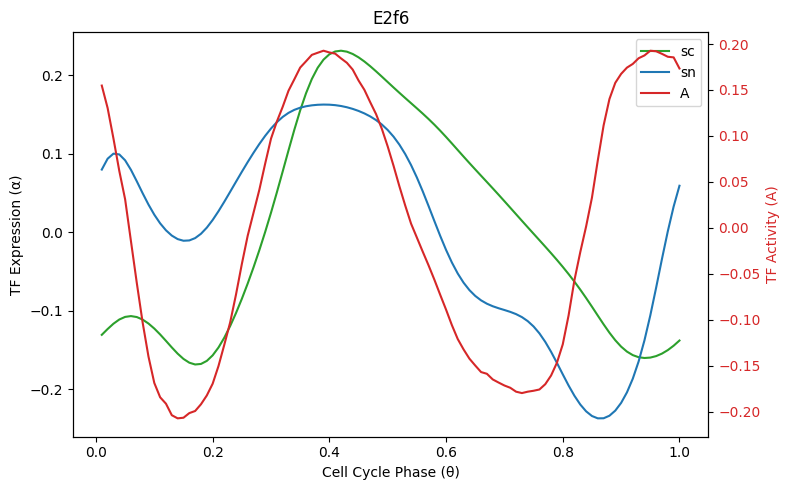

scRNA & A correlation : 0.242 (activator)

Expected activity range : [(0.01, 0.25), (0.63, 0.9)]
TF activity biological z-score : -9.43 (activator)



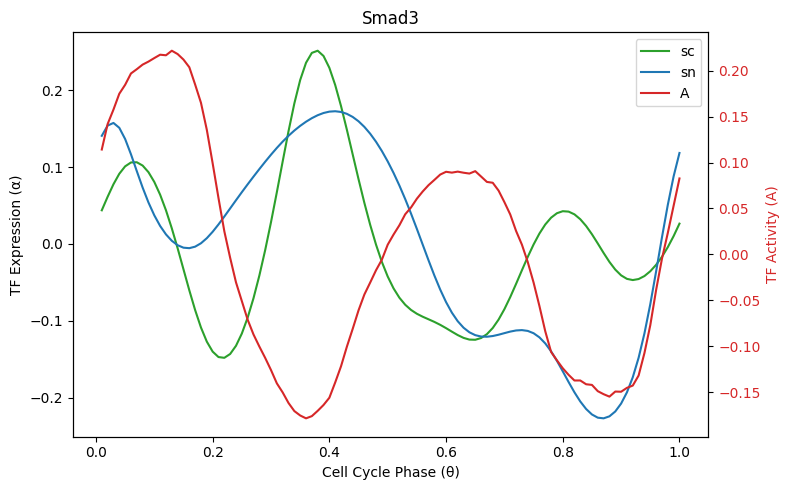

scRNA & A correlation : -0.345 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 0.51 (activator)



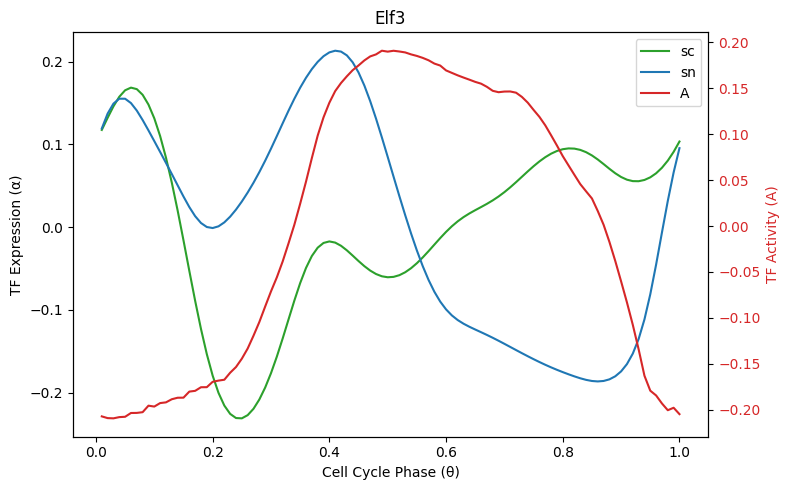

scRNA & A correlation : -0.343 (activator)

Expected activity range : [(0.25, 1)]
TF activity biological z-score : 16.96 (activator)



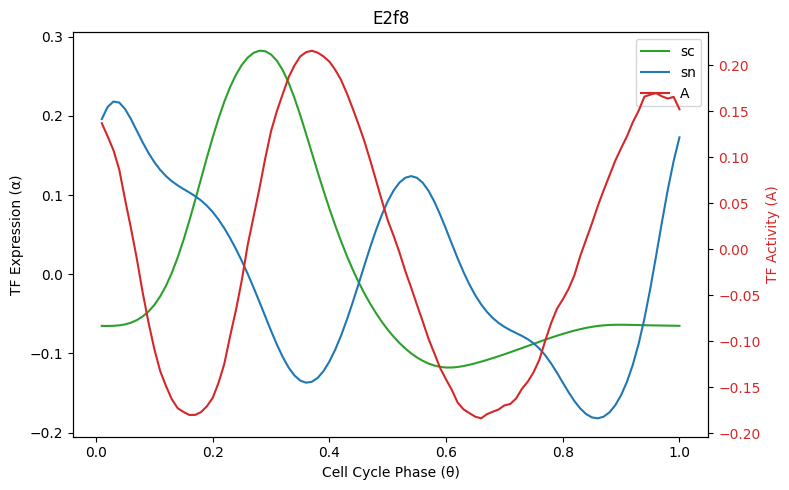

scRNA & A correlation : 0.430 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : -2.80 (activator)



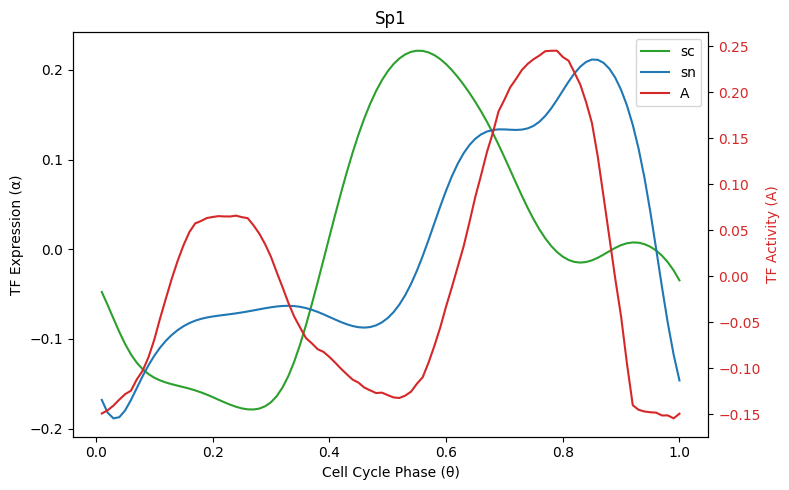

scRNA & A correlation : -0.164 (activator)

Expected activity range : [(0.1, 0.63)]
TF activity biological z-score : -3.19 (activator)



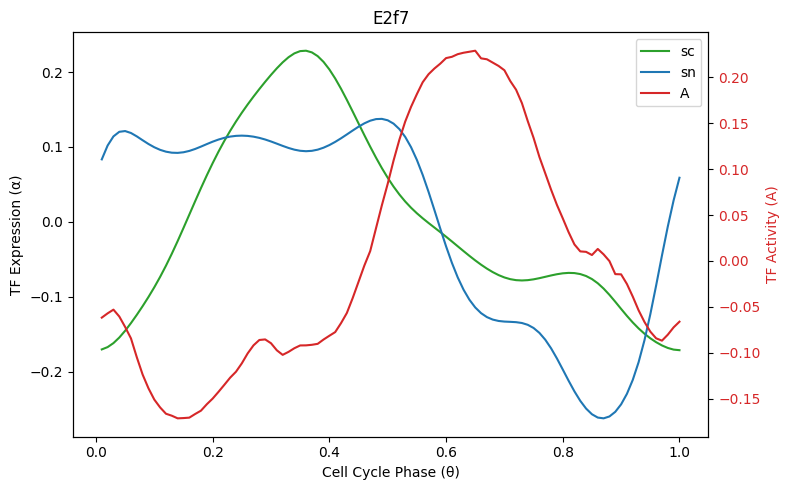

scRNA & A correlation : -0.215 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 13.45 (activator)



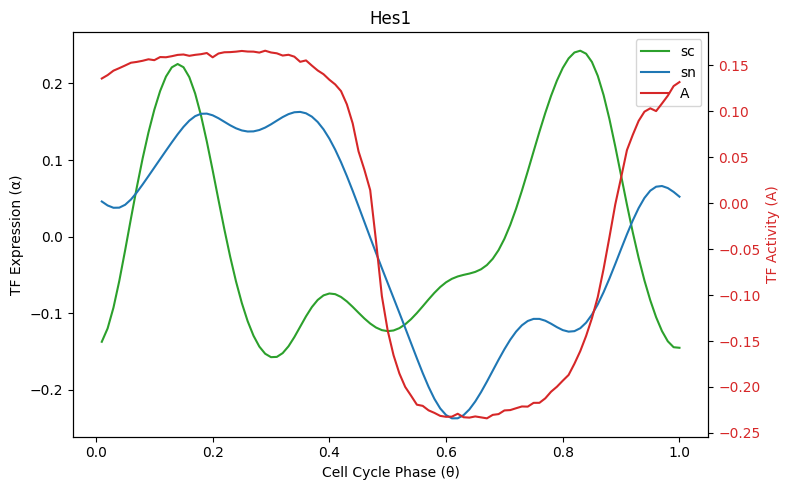

scRNA & A correlation : 0.153 (inhibitor)

Expected activity range : [(0.1, 0.5)]
TF activity biological z-score : -13.53 (inhibitor)



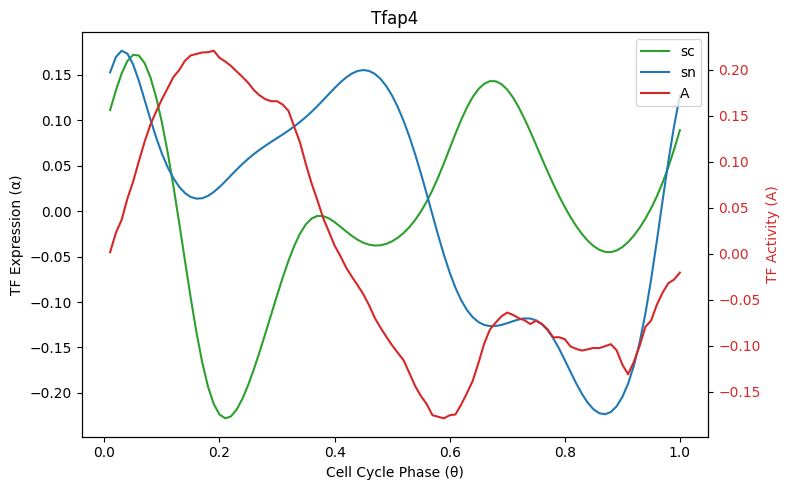

scRNA & A correlation : -0.328 (activator)

Expected activity range : [(0.63, 0.9)]
TF activity biological z-score : -10.76 (activator)



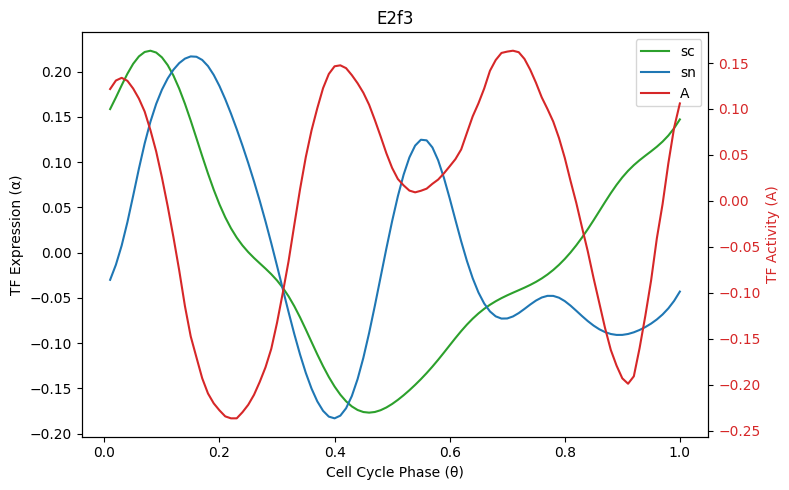

scRNA & A correlation : -0.335 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -4.92 (activator)



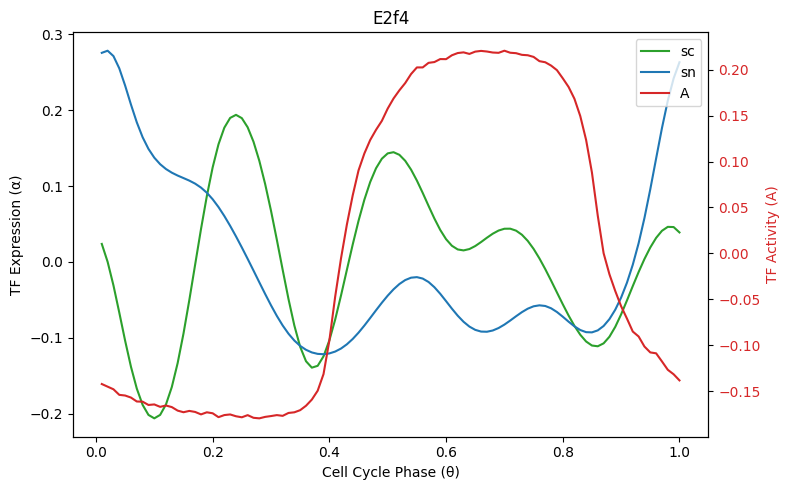

scRNA & A correlation : 0.084 (activator)

Expected activity range : [(0.01, 0.25)]
TF activity biological z-score : -17.18 (activator)



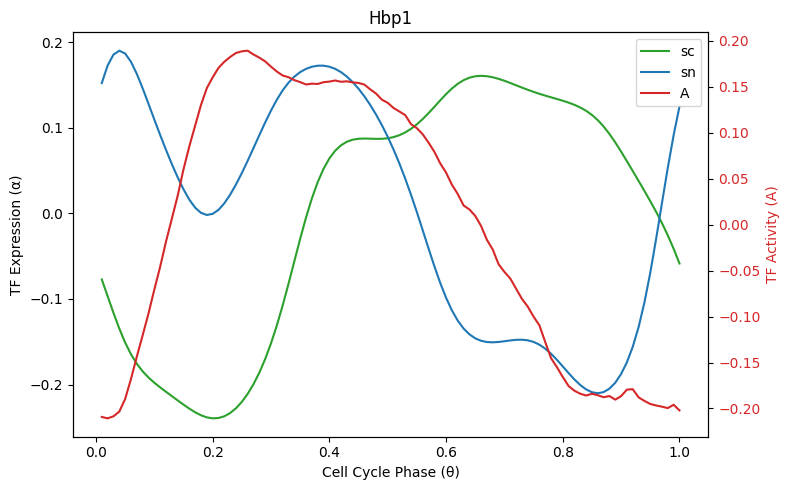

scRNA & A correlation : 0.273 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -9.38 (inhibitor)



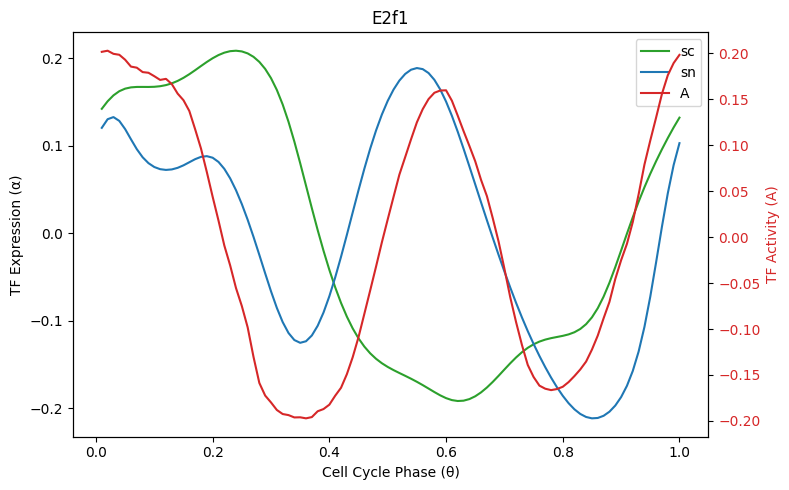

scRNA & A correlation : 0.055 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -0.50 (activator)



In [24]:
for tf in range(len(tf_names_filtered)):
    plot_TF_exp_activity(theta_smooth, alpha_sc_norm, alpha_sn_norm, A1_standard, tf_names, tf_names_filtered, tf)
    corr = spearmanr(alpha_sc_norm[tf], A1_standard[list(tf_names).index(tf_names_filtered[tf])])[0]
    action = "activator" if not expected_activity[tf_names_filtered[tf]]["inhibitory"] else "inhibitor"
    if (action == "inhibitor"):
        corr = -corr
    print(f"scRNA & A correlation : {corr:.3f} ({ action })\n")
    z_val = compute_tf_activity_difference(A1_standard[list(tf_names).index(tf_names_filtered[tf]), :], theta_smooth, expected_activity[tf_names_filtered[tf]]["ranges"], expected_activity[tf_names_filtered[tf]]["inhibitory"])
    
    print(f"Expected activity range : {expected_activity[tf_names_filtered[tf]]["ranges"]}")
    print(f"TF activity biological z-score : {z_val:.2f} ({ action })\n")